In this notebook, we'll learn how to use GANs to do semi-supervised learning.

In supervised learning, we have a training set of inputs $x$ and class labels $y$. We train a model that takes $x$ as input and gives $y$ as output.

In semi-supervised learning, our goal is still to train a model that takes $x$ as input and generates $y$ as output. However, not all of our training examples have a label $y$. We need to develop an algorithm that is able to get better at classification by studying both labeled $(x, y)$ pairs and unlabeled $x$ examples.

To do this for the SVHN dataset, we'll turn the GAN discriminator into an 11 class discriminator. It will recognize the 10 different classes of real SVHN digits, as well as an 11th class of fake images that come from the generator. The discriminator will get to train on real labeled images, real unlabeled images, and fake images. By drawing on three sources of data instead of just one, it will generalize to the test set much better than a traditional classifier trained on only one source of data.

## Notes:
- Here we have 3 sets of data:
    - real labeled data 
    - real unlabeled data 
    - fake images
- discriminator will have 11 classes (10 classes + fake)
- better generalization to test data than a traditional classifier 

In [ ]:
%matplotlib inline

import pickle as pkl
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [20]:
# There are two ways of solving this problem.
# One is to have the matmul at the last layer output all 11 classes.
# The other is to output just 10 classes, and use a constant value of 0 for
# the logit for the last class. This still works because the softmax only needs
# n independent logits to specify a probability distribution over n + 1 categories.
# We implemented both solutions here.
extra_class = 0

In [13]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [00:10, 17.2MB/s]                              
SVHN Training Set: 64.3MB [00:03, 19.6MB/s]                            


In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

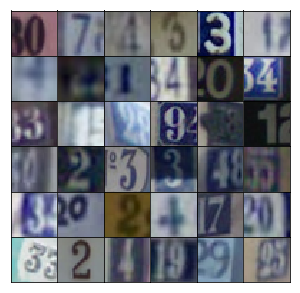

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

- Note: The SVHN dataset comes with lots of labels, but for the purpose of this exercise, we will pretend that there are only 1000. We use a `mask` to say which labels we will allow ourselves to use.

In [8]:
# a = np.ones((2,3,4,5))
# np.rollaxis(a,3).shape

(5, 2, 3, 4)

In [9]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=True, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        # The SVHN dataset comes with lots of labels, but for the purpose of this exercise,
        # we will pretend that there are only 1000.
        # We use this mask to say which labels we will allow ourselves to use.
        self.label_mask = np.zeros_like(self.train_y)
        self.label_mask[0:1000] = 1
        print('masked only 1000 labels out of {} to use.'.format(len(self.train_y)))
        
        self.train_x = np.rollaxis(self.train_x, 3)  # birngs the last axis at the beginning 
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.train_x = self.scaler(self.train_x)
        self.valid_x = self.scaler(self.valid_x)
        self.test_x = self.scaler(self.test_x)
        self.shuffle = shuffle
        
    def batches(self, batch_size, which_set="train"):
        x_name = which_set + "_x"
        y_name = which_set + "_y"
        
        num_examples = len(getattr(dataset, y_name))  # len(test_y) or len(train_y)
        if self.shuffle:
            idx = np.arange(num_examples)
            np.random.shuffle(idx)
            setattr(dataset, x_name, getattr(dataset, x_name)[idx])
            setattr(dataset, y_name, getattr(dataset, y_name)[idx])
            if which_set == "train":
                dataset.label_mask = dataset.label_mask[idx]
        
        dataset_x = getattr(dataset, x_name)   # train_x or test_x
        dataset_y = getattr(dataset, y_name)   # train_y or test_y 
        for ii in range(0, num_examples, batch_size):
            x = dataset_x[ii:ii+batch_size]
            y = dataset_y[ii:ii+batch_size]
            
            if which_set == "train":
                # When we use the data for training, we need to include
                # the label mask, so we can pretend we don't have access
                # to some of the labels, as an exercise of our semi-supervised
                # learning ability
                yield x, y, self.label_mask[ii:ii+batch_size]
            else:
                yield x, y

In [10]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    y = tf.placeholder(tf.int32, (None), name='y')
    label_mask = tf.placeholder(tf.int32, (None), name='label_mask')
    
    return inputs_real, inputs_z, y, label_mask

![DCGAN Generator](assets/dcgan.png)

* Note: here we start with 4,4,128*n and end up with 16, 16, 128 then 32, 32, 3 
* Generator is basically the same as the DCGAN

In [16]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True, size_mult=128):
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * size_mult * 4)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, size_mult * 4))
        # batch norm + leaky RELU 
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # here (4 , 4 , 512)
        
        # T_CONV + Batch Norm + Leaky RELU
        x2 = tf.layers.conv2d_transpose(x1, size_mult * 2, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # here (8, 8, 256)
        
        # T_CONV + Batch Norm + Leaky RELU
        x3 = tf.layers.conv2d_transpose(x2, size_mult, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # here (16, 16, 128)
        
        # Output layer: T_CONV (with 3 filters) + logits (to get the images)
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # here (32, 32, output_dim=3)
        out = tf.tanh(logits)
        
        return out

* Notes:
* Discriminator is the msot important part of this project. It's a DCGAN style Disc. with some differences. 
    - We don't use any pooling and just use strides to reduce dimensions of feature maps 
    - Don't use BN at the first layer, as we cannot assert if the mean and variance of the pixels from the generator are correct
    - We use Dropout in some layers (more frequent than the others): it's a generalization technique, and helps to make sure test error is not too much higher than train error. Since we only use 1000 labeled samples, it's very important to ensure overfitting is not happening 
    - leaky RELU: helps gradient pass cleanly to the layer below. It really needs to propagate cleanly through the discrimintaor as it's the signal for the generator 

In [31]:
def discriminator(x, reuse=False, alpha=0.2, drop_rate=0., num_classes=10, size_mult=64):
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.dropout(x, rate=drop_rate/2.5)  # Q what is this Dropout 4?
        
        # Input layer is 32x32x3
        
        # CONV + leaky RELU + Dropout -> No BN first layer 
        x1 = tf.layers.conv2d(x, size_mult, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1, rate=drop_rate)
        # here (16, 16, 64)
        
        # CONV + BN + leaky RELU
        x2 = tf.layers.conv2d(relu1, size_mult, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        # here (8, 8, 64)
        
        # CONV + BN + leaky RELU + Dropout
        x3 = tf.layers.conv2d(relu2, size_mult, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=drop_rate)
        # here (4, 4, 64)
        
        # CONV + BN + leaky RELU
        x4 = tf.layers.conv2d(relu3, 2 * size_mult, 3, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # here (4, 4, 128)       
        
        # CONV + BN + leaky RELU
        x5 = tf.layers.conv2d(relu4, 2 * size_mult, 3, strides=1, padding='same')
        bn5 = tf.layers.batch_normalization(x5, training=True)
        relu5 = tf.maximum(alpha * bn5, bn5)
        print('relu5 shape:' , relu5.get_shape())
        # here (4, 4, 128)       
        
        # CONV + BN + leaky RELU + Dropout
        x6 = tf.layers.conv2d(relu5, 2 * size_mult, 3, strides=2, padding='same')
        bn6 = tf.layers.batch_normalization(x6, training=True)
        relu6 = tf.maximum(alpha * bn6, bn6)
        relu6 = tf.layers.dropout(relu6, rate=drop_rate)
        # here (2, 2, 128)   
        print('relu6 shape:' , relu6.get_shape())
        
        # CONV + leaky RELU + features 
        x7 = tf.layers.conv2d(relu5, 2 * size_mult, 3, strides=1, padding='valid')
        # This layer is used for the feature matching loss, which only works if
        # the means can be different when the discriminator is run on the data than
        # when the discriminator is run on the generator samples.
        # Don't use bn on this layer, because bn would set the mean of each feature
        # to the bn mu parameter (bias).
        # Tim used a weight normalization method to initialize wights in a particular
        # way that we can still use the BN. but here we just skip BN. 
        
        relu7 = tf.maximum(alpha * x7, x7)
        
        # Flatten it by global average pooling
        # Features used for feature matching are basically output of a GAP layer
        # We don't have a GAP layer in tf yet, but we can avg over dimensions 1,2 
        # remember: (batch_size, w, h, channels)
        features = tf.reduce_mean(relu7, axis=(1,2))
        
        # Set class_logits to be the inputs to a softmax distribution over the different classes
        # We have two options here: either to output 11 classes, or to output 10 classes
        # B/C if we know prob dist of 10 classes, we can get the one for the 11th class as 1- sum(10 classes)
        # so we can set the logits for one class to 0, and let the others control the prob dist
        # so we use extra_class param here
        class_logits = tf.layers.dense(features, num_classes + extra_class)
        
        # softmax output 
        softmax_out = tf.nn.softmax(class_logits)
        
        # Set gan_logits such that P(input is real | input) = sigmoid(gan_logits).
        # Keep in mind that class_logits gives you the probability distribution over all the real
        # classes and the fake class. You need to work out how to transform this multiclass softmax
        # distribution into a binary real-vs-fake decision that can be described with a sigmoid.
        # Numerical stability is very important.
        # You'll probably need to use this numerical stability trick:
        # log sum_i exp a_i = m + log sum_i exp(a_i - m).
        # This is numerically stable when m = max_i a_i.
        # (It helps to think about what goes wrong when...
        #   1. One value of a_i is very large
        #   2. All the values of a_i are very negative
        # This trick and this value of m fix both those cases, but the naive implementation and
        # other values of m encounter various problems)
        
        # split class_logits tensor into two tensors with sizes [num_classes, 1] along axis 1
        print('class_logits ',class_logits.get_shape())
        
        if extra_class:  # we have num_classes + 1 total logits
            real_class_logits, fake_class_logits = tf.split(class_logits, [num_classes,1], 1)
            print('real_class_logits ', real_class_logits.get_shape())
            print('fake_class_logits ', fake_class_logits.get_shape())
            #assert fake_class_logits.get_shape()[1] == 1, fake_class_logits.get_shape()
            fake_class_logits = tf.squeeze(fake_class_logits)
        else: # we have num_classes logits for real, and 0 for fake
            real_class_logits = class_logits
            fake_class_logits = 0.0
        mx = tf.reduce_max(real_class_logits ,axis = 1, keep_dims=True) # retains reduced dimensions with length 1
        
        real_class_logits = real_class_logits-mx
        gan_logits =  tf.log(tf.reduce_sum(tf.exp(real_class_logits), axis=1)) - fake_class_logits + tf.squeeze(mx)
        
        
        return softmax_out, class_logits, gan_logits, features

### Derivation:

In sigmoid, we have $$p_0  = \frac{1}{1 + e ^{-\beta x}}, \quad p_1  = \frac{e ^{-\beta x}}{1 + e ^{-\beta x}},$$ where $\beta x$ is the sigmoid logit. 

In an n-class softmax, we have $\beta_0 x, \beta_1 x, ... , \beta_n x $ as the logits. So if 0 corresponds to the fake class, and $1, \ldots, n$ correspond to real classes, we will have: $$
p_0  = \frac{e ^{\beta_0 x}}{e ^{\beta_0 x} + e ^{\beta_1 x} + \ldots + e ^{\beta_n x}}, \quad  
p_1  = \frac{e ^{\beta_1 x} + \ldots + e ^{\beta_n x}}{e ^{\beta_0 x} + e ^{\beta_1 x} + \ldots + e ^{\beta_n x}}, \quad , $$ so
$$
p_0  = \frac{1}{1 + e ^{(\beta_1  - \beta_0) x} + \ldots + e ^{(\beta_n - \beta_0) x}}, \quad  
p_1  = \frac{e ^{(\beta_1  - \beta_0) x} + \ldots + e ^{(\beta_n - \beta_0) x}}{1 + e ^{(\beta_1  - \beta_0) x} + \ldots + e ^{(\beta_n - \beta_0) x}}, \quad , $$
Hence:
$$logit = - \beta x = log( e ^{(\beta_1  - \beta_0) x} + \ldots + e ^{(\beta_n - \beta_0) x}) $$
$$\quad =  log( e ^{(\beta_1  ) x} + \ldots + e ^{(\beta_n) x}) - \beta_0 x $$
$$\quad =  log \sum_{i=1,...} {e ^{(\beta_i x )}} - \beta_0 x $$
$$\quad =  max + log \sum_{i=1,...} {e ^{(\beta_i x - max)}} - \beta_0 x $$

In [62]:
def model_loss(input_real, input_z, output_dim, y, num_classes, label_mask, alpha=0.2, drop_rate=0.):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param output_dim: The number of channels in the output image (usually 3)
    :param y: Integer class labels
    :param num_classes: The number of classes
    :param alpha: The slope of the left half of leaky ReLU activation
    :param drop_rate: The probability of dropping a hidden unit
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    
    # These numbers multiply the size of each layer of the generator and the discriminator,
    # respectively. You can reduce them to run your code faster for debugging purposes.
    g_size_mult = 32
    d_size_mult = 64
    
    # Here we run the generator and the discriminator
    g_model_out = generator(input_z, output_dim, alpha=alpha, size_mult=g_size_mult)
    d_on_data = discriminator(input_real, alpha=alpha, drop_rate=drop_rate, size_mult=d_size_mult)
    d_model_real_soft, class_logits_on_data, gan_logits_on_data, data_features = d_on_data  # unpacking 
    d_on_samples = discriminator(g_model_out, reuse=True, alpha=alpha, drop_rate=drop_rate, size_mult=d_size_mult)
    d_model_fake_soft, class_logits_on_samples, gan_logits_on_samples, sample_features = d_on_samples
    
    
    # Discriminator loss
    #    d_loss  = d_loss_gan + d_loss_class, where
    #    d_loss_gan =  d_loss_real + d_loss_fake  (similar to DCGAn)
    
    # Here we compute `d_loss`, the loss for the discriminator.
    # This should combine two different losses:
    #  1. The loss for the GAN problem, where we minimize the cross-entropy for the binary
    #     real-vs-fake classification problem.
    #  2. The loss for the SVHN digit classification problem, where we minimize the cross-entropy
    #     for the multi-class softmax. For this one we use the labels. Don't forget to ignore
    #     use `label_mask` to ignore the examples that we are pretending are unlabeled for the
    #     semi-supervised learning problem.
    
    #d_loss_real: disc. logits of real data input with labels being one -> disc try to learn they're real
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gan_logits_on_data, 
                                                                         labels=tf.ones_like(gan_logits_on_data) ))
    #d_loss_fake: disc. logits of fake data with labels being zero -> disc try to learn they're fake
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gan_logits_on_samples, 
                                                                        labels=tf.zeros_like(gan_logits_on_samples)))
    d_loss_gan =  d_loss_real + d_loss_fake 
    
    # d_loss_class: disc. softmax logits of the real data 
    # labels -> one hot encode
    print("shape of y:" + str(y.get_shape()))
    one_hot_labels = tf.one_hot(tf.squeeze(y), num_classes + extra_class, dtype=tf.float32) # float32: to mask them with label_mask
    # calc cross entropy for all labeled data
    class_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=class_logits_on_data, labels=one_hot_labels)
    class_cross_entropy = tf.squeeze(class_cross_entropy)
    
    label_mask = tf.squeeze(tf.to_float(label_mask))  # convert to float to multiply it to cross entropy vals
    
    d_loss_class = tf.reduce_sum(class_cross_entropy * label_mask) / tf.maximum(1., tf.reduce_sum(label_mask)) 
                                                                        # mean only over masked labels
    
    d_loss  = d_loss_gan + d_loss_class
          
    # Generator loss
    # Here we set `g_loss` to the "feature matching" loss invented by Tim Salimans at OpenAI.
    # This loss consists of minimizing the absolute difference between the expected features
    # on the data and the expected features on the generated samples.
    # This loss works better for semi-supervised learning than the tradition GAN losses.
    
    print('data features shape'+ str(data_features.get_shape()))
    print('sample features shape'+ str(sample_features.get_shape()))
    expected_data_features  = tf.reduce_mean(data_features, axis=0)
    expected_sample_features = tf.reduce_mean(sample_features, axis=0)
    g_loss = tf.reduce_mean(tf.abs(expected_data_features - expected_sample_features))

    pred_class = tf.cast(tf.argmax(class_logits_on_data, 1), tf.int32)
    eq = tf.equal(tf.squeeze(y), pred_class)
    correct = tf.reduce_sum(tf.to_float(eq))
    masked_correct = tf.reduce_sum(label_mask * tf.to_float(eq))
    
    return d_loss, g_loss, correct, masked_correct, g_model_out

In [63]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and biases to update. Get them separately for the discriminator and the generator
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # Minimize both players' costs simultaneously
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    shrink_lr = tf.assign(learning_rate, learning_rate * 0.9)
    
    return d_train_opt, g_train_opt, shrink_lr

In [64]:
class GAN:
    """
    A GAN model.
    :param real_size: The shape of the real data.
    :param z_size: The number of entries in the z code vector.
    :param learnin_rate: The learning rate to use for Adam.
    :param num_classes: The number of classes to recognize.
    :param alpha: The slope of the left half of the leaky ReLU activation
    :param beta1: The beta1 parameter for Adam.
    """
    def __init__(self, real_size, z_size, learning_rate, num_classes=10, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.learning_rate = tf.Variable(learning_rate, trainable=False)
        inputs = model_inputs(real_size, z_size)
        self.input_real, self.input_z, self.y, self.label_mask = inputs
        self.drop_rate = tf.placeholder_with_default(.5, (), "drop_rate")  # it passes through 0.5, 
                                                                        #when its output is not fed
        
        loss_results = model_loss(self.input_real, self.input_z,
                                  real_size[2], self.y, num_classes,
                                  label_mask=self.label_mask,
                                  alpha=0.2,
                                  drop_rate=self.drop_rate)
        self.d_loss, self.g_loss, self.correct, self.masked_correct, self.samples = loss_results
        
        self.d_opt, self.g_opt, self.shrink_lr = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)

In [65]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img)
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [66]:
def train(net, dataset, epochs, batch_size, figsize=(5,5)):
    
    saver = tf.train.Saver()
    sample_z = np.random.normal(0, 1, size=(50, z_size))

    samples, train_accuracies, test_accuracies = [], [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            print("Epoch",e)
            
            t1e = time.time()
            num_examples = 0
            num_correct = 0
            for x, y, label_mask in dataset.batches(batch_size):
                assert 'int' in str(y.dtype)
                steps += 1
                num_examples += label_mask.sum()

                # Sample random noise for G
                batch_z = np.random.normal(0, 1, size=(batch_size, z_size))

                # Run optimizers
                t1 = time.time()
                _, _, correct = sess.run([net.d_opt, net.g_opt, net.masked_correct],
                                         feed_dict={net.input_real: x, net.input_z: batch_z,
                                                    net.y : y, net.label_mask : label_mask})
                t2 = time.time()
                num_correct += correct

            sess.run([net.shrink_lr])
            
            
            train_accuracy = num_correct / float(num_examples)
            
            print("\t\tClassifier train accuracy: ", train_accuracy)
            
            num_examples = 0
            num_correct = 0
            for x, y in dataset.batches(batch_size, which_set="test"):
                assert 'int' in str(y.dtype)
                num_examples += x.shape[0]

                correct, = sess.run([net.correct], feed_dict={net.input_real: x,
                                                   net.y : y,
                                                   net.drop_rate: 0.})
                num_correct += correct
            
            test_accuracy = num_correct / float(num_examples)
            print("\t\tClassifier test accuracy", test_accuracy)
            print("\t\tStep time: ", t2 - t1)
            t2e = time.time()
            print("\t\tEpoch time: ", t2e - t1e)
            
            
            gen_samples = sess.run(
                                   net.samples,
                                   feed_dict={net.input_z: sample_z})
            samples.append(gen_samples)
            _ = view_samples(-1, samples, 5, 10, figsize=figsize)
            plt.show()
            
            
            # Save history of accuracies to view after training
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
            

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return train_accuracies, test_accuracies, samples

In [67]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [68]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0003

net = GAN(real_size, z_size, learning_rate)

relu5 shape: (?, 4, 4, 128)
relu6 shape: (?, 2, 2, 128)
class_logits  (?, 10)
relu5 shape: (?, 4, 4, 128)
relu6 shape: (?, 2, 2, 128)
class_logits  (?, 10)
shape of y:<unknown>
data features shape(?, 128)
sample features shape(?, 128)


masked only 1000 labels out of 73257 to use.
Epoch 0
		Classifier train accuracy:  0.149
		Classifier test accuracy 0.19591272280270436
		Step time:  0.050269126892089844
		Epoch time:  31.680388927459717


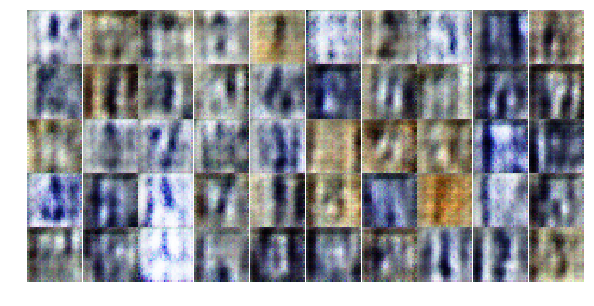

Epoch 1
		Classifier train accuracy:  0.268
		Classifier test accuracy 0.3243700061462815
		Step time:  0.016154766082763672
		Epoch time:  30.114404916763306


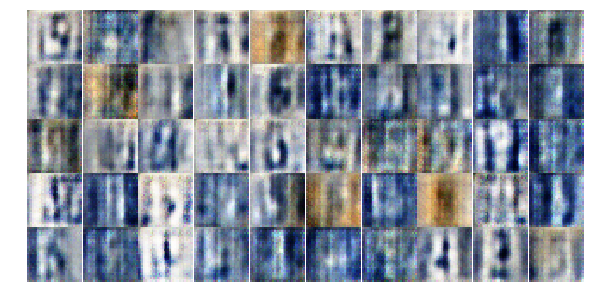

Epoch 2
		Classifier train accuracy:  0.466
		Classifier test accuracy 0.5553933620159803
		Step time:  0.024311304092407227
		Epoch time:  29.928741216659546


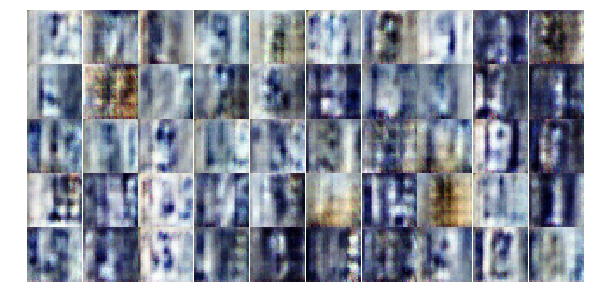

Epoch 3
		Classifier train accuracy:  0.626
		Classifier test accuracy 0.5971112476951445
		Step time:  0.01777195930480957
		Epoch time:  29.291083097457886


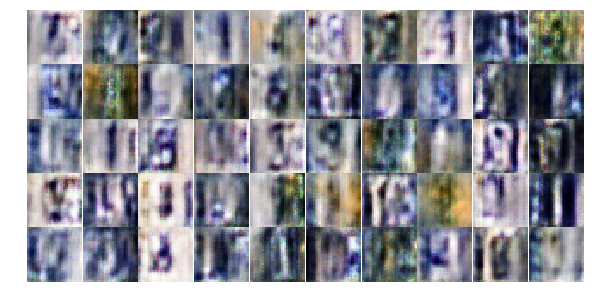

Epoch 4
		Classifier train accuracy:  0.758
		Classifier test accuracy 0.6253841425937308
		Step time:  0.018136978149414062
		Epoch time:  29.522292613983154


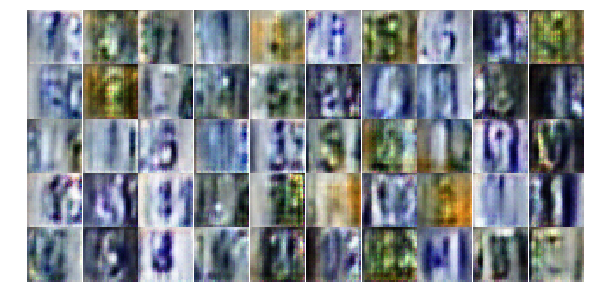

Epoch 5
		Classifier train accuracy:  0.814
		Classifier test accuracy 0.6699446834665027
		Step time:  0.02199411392211914
		Epoch time:  29.781166076660156


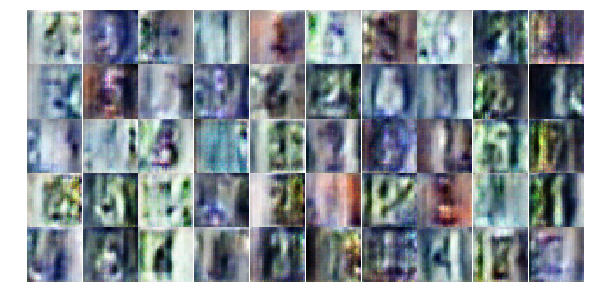

Epoch 6
		Classifier train accuracy:  0.855
		Classifier test accuracy 0.6608789182544561
		Step time:  0.023411989212036133
		Epoch time:  29.372141122817993


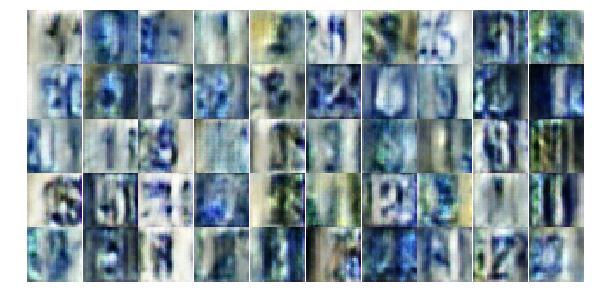

Epoch 7
		Classifier train accuracy:  0.883
		Classifier test accuracy 0.6606484326982176
		Step time:  0.02149200439453125
		Epoch time:  29.295560359954834


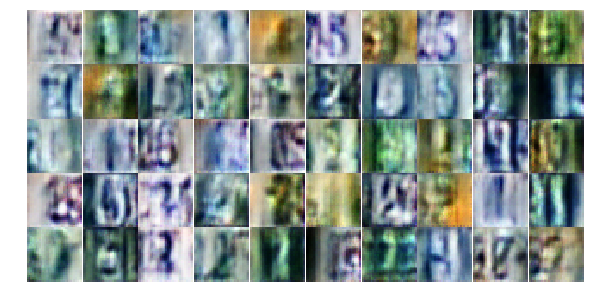

Epoch 8
		Classifier train accuracy:  0.906
		Classifier test accuracy 0.702519975414874
		Step time:  0.032917022705078125
		Epoch time:  29.534823894500732


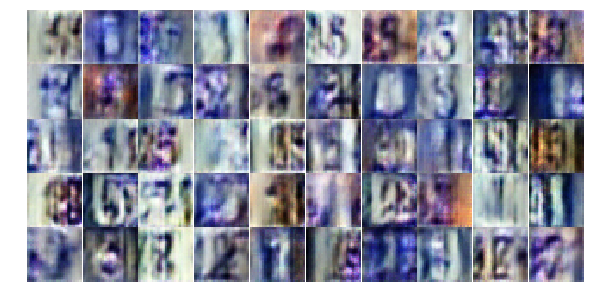

Epoch 9
		Classifier train accuracy:  0.904
		Classifier test accuracy 0.6984480639213276
		Step time:  0.022046804428100586
		Epoch time:  29.15512490272522


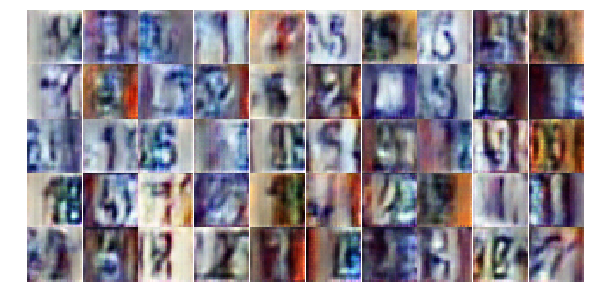

Epoch 10
		Classifier train accuracy:  0.922
		Classifier test accuracy 0.7056699446834666
		Step time:  0.019402503967285156
		Epoch time:  29.434892654418945


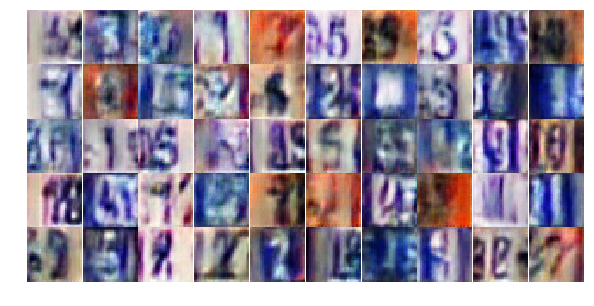

Epoch 11
		Classifier train accuracy:  0.92
		Classifier test accuracy 0.7150430239704979
		Step time:  0.021806955337524414
		Epoch time:  29.547741413116455


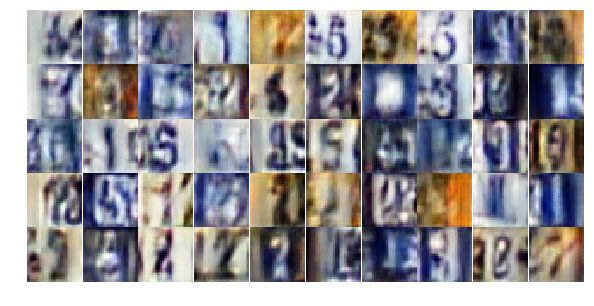

Epoch 12
		Classifier train accuracy:  0.931
		Classifier test accuracy 0.7157344806392133
		Step time:  0.021369457244873047
		Epoch time:  56.50967502593994


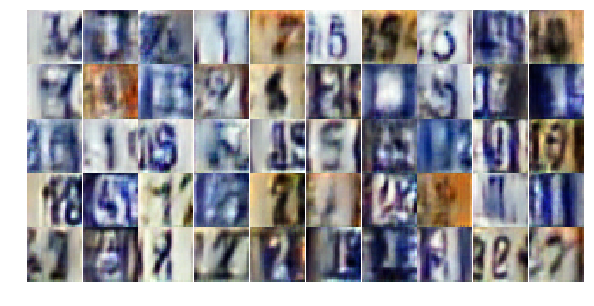

Epoch 13
		Classifier train accuracy:  0.93
		Classifier test accuracy 0.7200368776889982
		Step time:  0.022759437561035156
		Epoch time:  31.0315203666687


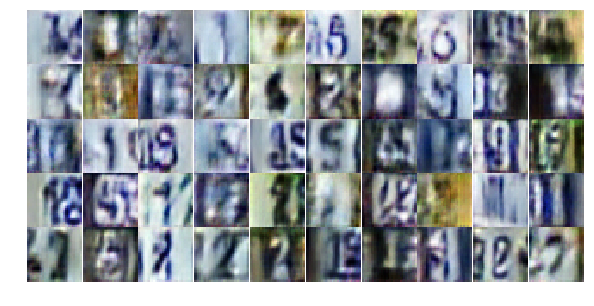

Epoch 14
		Classifier train accuracy:  0.937
		Classifier test accuracy 0.7266441303011678
		Step time:  0.019202709197998047
		Epoch time:  29.217087745666504


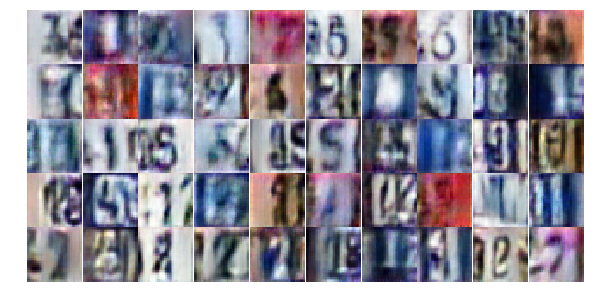

Epoch 15
		Classifier train accuracy:  0.932
		Classifier test accuracy 0.724339274738783
		Step time:  0.01722407341003418
		Epoch time:  28.42520809173584


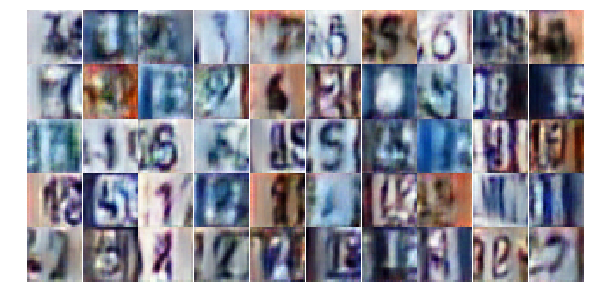

Epoch 16
		Classifier train accuracy:  0.938
		Classifier test accuracy 0.7283343577135832
		Step time:  0.019340038299560547
		Epoch time:  29.886216402053833


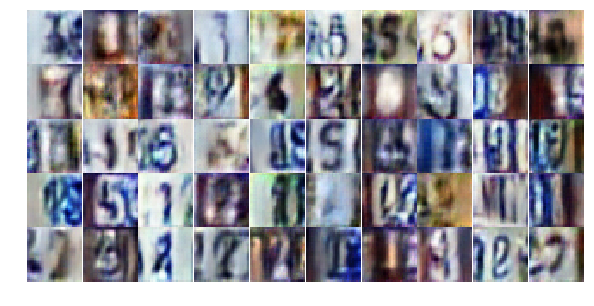

Epoch 17
		Classifier train accuracy:  0.938
		Classifier test accuracy 0.7294099569760295
		Step time:  0.020473718643188477
		Epoch time:  29.639594554901123


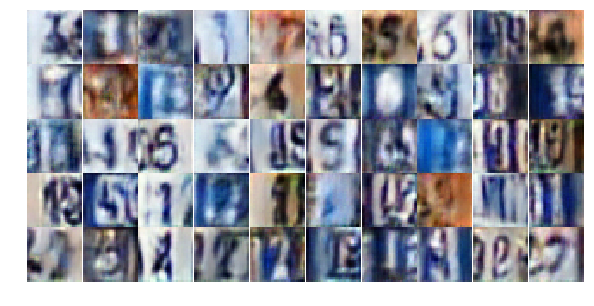

Epoch 18
		Classifier train accuracy:  0.937
		Classifier test accuracy 0.7259526736324524
		Step time:  0.020060300827026367
		Epoch time:  29.183037996292114


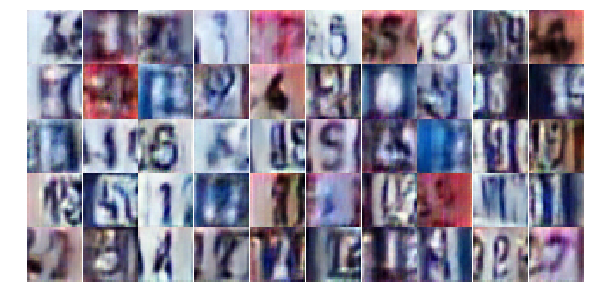

Epoch 19
		Classifier train accuracy:  0.937
		Classifier test accuracy 0.7293331284572834
		Step time:  0.020650148391723633
		Epoch time:  29.33963966369629


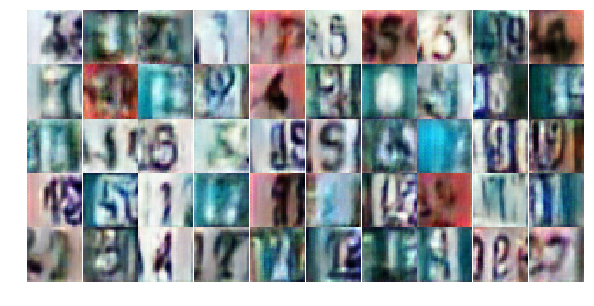

Epoch 20
		Classifier train accuracy:  0.936
		Classifier test accuracy 0.730639213275968
		Step time:  0.022405385971069336
		Epoch time:  29.045610904693604


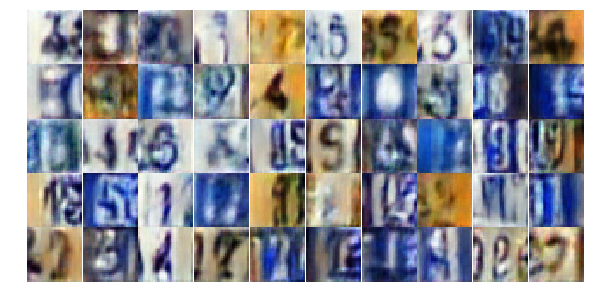

Epoch 21
		Classifier train accuracy:  0.938
		Classifier test accuracy 0.7236478180700676
		Step time:  0.02268695831298828
		Epoch time:  34.15760612487793


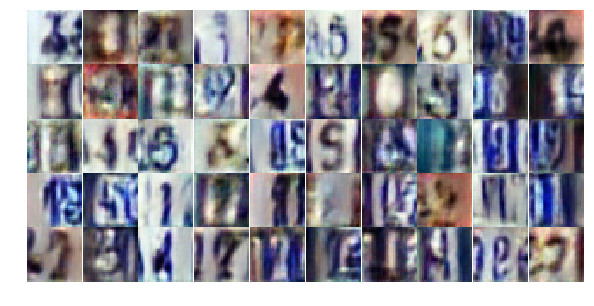

Epoch 22
		Classifier train accuracy:  0.936
		Classifier test accuracy 0.7244929317762754
		Step time:  0.02172565460205078
		Epoch time:  70.86500120162964


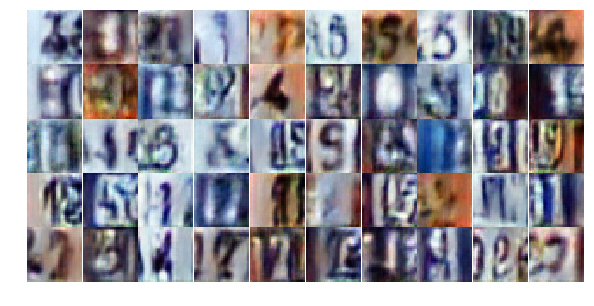

Epoch 23
		Classifier train accuracy:  0.938
		Classifier test accuracy 0.7285648432698217
		Step time:  0.019382476806640625
		Epoch time:  66.30885148048401


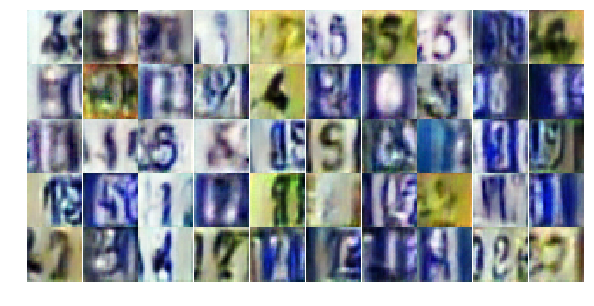

Epoch 24
		Classifier train accuracy:  0.938
		Classifier test accuracy 0.7254917025199754
		Step time:  0.023665428161621094
		Epoch time:  30.599703073501587


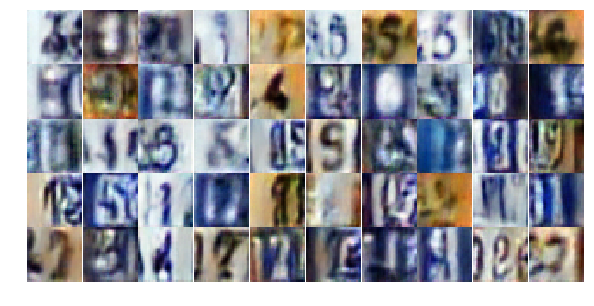

In [70]:
dataset = Dataset(trainset, testset)

batch_size = 64
epochs = 25
train_accuracies, test_accuracies, samples = train(net,
                                                   dataset,
                                                   epochs,
                                                   batch_size,
                                                   figsize=(10,5))

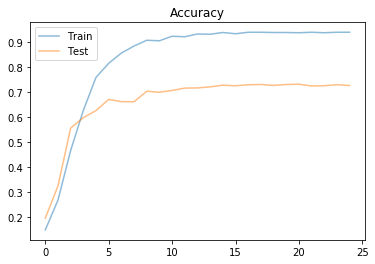

In [71]:
fig, ax = plt.subplots()
plt.plot(train_accuracies, label='Train', alpha=0.5)
plt.plot(test_accuracies, label='Test', alpha=0.5)
plt.title("Accuracy")
plt.legend()

When you run the fully implemented semi-supervised GAN, you should usually find that the test accuracy peaks at 69-71%. It should definitely stay above 68% fairly consistently throughout the last several epochs of training.

This is a little bit better than a [NIPS 2014 paper](https://arxiv.org/pdf/1406.5298.pdf) that got 64% accuracy on 1000-label SVHN with variational methods. However, we still have lost something by not using all the labels. If you re-run with all the labels included, you should obtain over 80% accuracy using this architecture (and other architectures that take longer to run can do much better).

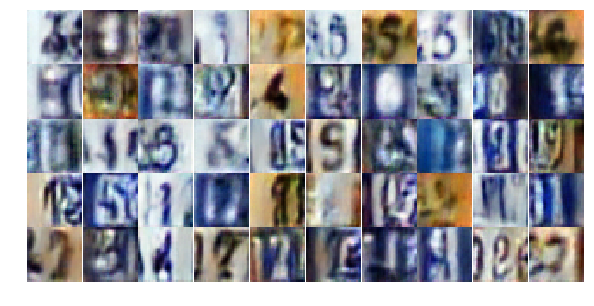

In [72]:
_ = view_samples(-1, samples, 5, 10, figsize=(10,5))

In [75]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [74]:
for ii in range(len(samples)):
    fig, ax = view_samples(ii, samples, 5, 10, figsize=(10,5))
    fig.savefig('images/samples_{:03d}.png'.format(ii))
    plt.close()

Congratulations! You now know how to train a semi-supervised GAN. This exercise is stripped down to make it run faster and to make it simpler to implement. In the original work by Tim Salimans at OpenAI, a GAN using [more tricks and more runtime](https://arxiv.org/pdf/1606.03498.pdf) reaches over 94% accuracy using only 1,000 labeled examples.